<a href="https://colab.research.google.com/github/bramyeon/korea-happiness-ext/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Korea Happiness Extended:</b> Model-Based Analysis
Summer Institute in Computational Social Science (SICSS-Korea) 2024 Team Project Extension  

<b>Author:</b> Bryan Nathanael Wijaya ([bryannwijaya@kaist.ac.kr](mailto:bryannwijaya@kaist.ac.kr))  
<b>Team Members (ABC order):</b> Ju Hee Jeung, Kyungmin Lee, Yumi Park

### If you find anything suspicious or wrong, do not hesitate to let me know via [email](mailto:bryannwijaya@kaist.ac.kr). Happy coding!


In [1]:
#@title Setting up prerequisites and uploading model weights
#@markdown You only need to run this cell once. Refer to the `README.md` in our Github repository [here](https://github.com/bramyeon/korea-happiness-ext.git) about the different `model_type` variations. The models were trained using the four different datasets; feel free to choose any model for your analysis. Do not change the `LUCKY_NUMBER` if you are not sure.

#@markdown **Simply put, more features means more complexity!** Thus, `korea-all` is more complex than `korea-complex`, which is more complex than `korea-medium`, which is more complex than `korea-basic`, which is more complex than `korea-simple`.

!git clone https://github.com/bramyeon/korea-happiness-ext.git
print()

from google.colab import files
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy import stats

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")
model_type = "korea-basic (58 features)" #@param ['korea-all (308 features)', 'korea-complex (141 features)', 'korea-medium (85 features)', 'korea-basic (58 features)', 'korea-simple (39 features)']
LUCKY_NUMBER = 42 #@param {type:"integer"}

model_type = model_type.split()[0]

num_layers_dict = {
    'korea-all': 6,
    'korea-complex': 4,
    'korea-medium': 6,
    'korea-basic': 2,
    'korea-simple': 8
}

data_name = model_type
num_layers = num_layers_dict[data_name]
epochs = 200

print(f"\nModel was trained on the `{data_name}` dataset,\nwith {num_layers} layers and {epochs} epochs.")

class Regressor(nn.Module):
    def __init__(self, features):
        super(Regressor, self).__init__()


        self.layers = []
        for i in range(len(features)-1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(features[-1], 1))

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

class Model:
    def __init__(self, features, lr, beta1, beta2, epochs):
        self.features = features
        self.model = Regressor(self.features)
        self.model = self.model.to(device)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        self.train_loss_epoch = None
        self.test_err_epoch = None

    def update(self, train_loss_epoch, test_err_epoch):
        self.train_loss_epoch = train_loss_epoch
        self.test_err_epoch = test_err_epoch

all_in_dict = {
    'korea-all': 309,
    'korea-complex': 142,
    'korea-medium': 86,
    'korea-basic': 59,
    'korea-simple': 40
}

all_in = all_in_dict[model_type]

lr = 1e-3
beta1, beta2 = 0.9, 0.999

models = { 10: Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*8, LUCKY_NUMBER*16, LUCKY_NUMBER*8, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
           8: Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*8, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
           6: Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
           4: Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
           2: Model([all_in, LUCKY_NUMBER], lr, beta1, beta2, epochs)}

model = models[num_layers]
checkpoint = torch.load(f"korea-happiness-ext/checkpoints/{data_name}-{num_layers}-{epochs}.pth")#(filename)
model.model.load_state_dict(checkpoint)
model.model.to(device)
model.model.eval()

test_data = f"korea-happiness-ext/test-data/{data_name}-test.csv"
df_test = pd.read_csv(test_data)
df_test['bias'] = -1.
del df_test['happiness_ladder']

features_dict = dict()
for i, col in enumerate(df_test.columns):
    features_dict[col] = i

df_test_data = torch.tensor(df_test.values, dtype=torch.float).to(device)
print("Test data scenarios are successfully loaded.")

codes = pd.read_excel(f'korea-happiness-ext/code-stats.xlsx')
ranges = {}
for i in range(len(codes)):
    ranges[codes['code'][i]] = [codes['range-min'][i], codes['range-max'][i]]

Cloning into 'korea-happiness-ext'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 121 (delta 52), reused 43 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 25.27 MiB | 13.60 MiB/s, done.
Resolving deltas: 100% (52/52), done.

Device: cuda

Model was trained on the `korea-basic` dataset,
with 2 layers and 200 epochs.


<ipython-input-1-3cd4cc0b0c04>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"korea-happiness-ext/checkpoints/{data_name}-{num_layers}-{epochs}.

Test data scenarios are successfully loaded.


Tips: The recommended `range_min` and `range_max` for variable `PM2.5` are 6.3333 and 31.3333, respectively.

To set the range manually, uncheck `automatic_range`.



Plotting: 100%|██████████| 3118/3118 [00:14<00:00, 219.00it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

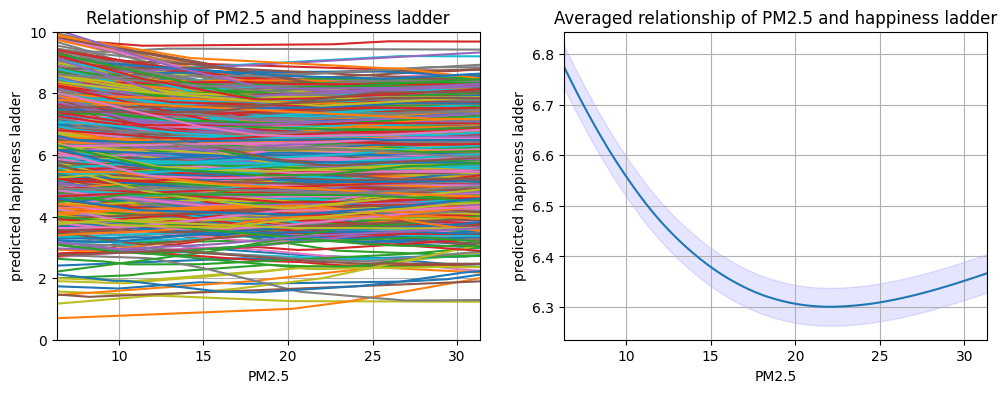

In [9]:
#@title Trend analysis
#@markdown Choose which `variable` you would like to analyze for its relationship with the happiness ladder. Check `automatic_range` to use the recommended sampling range for your `variable`, or alternatively, input the appropriate `range_min` and `range_max` to define your sampling range manually. Here, `num_samples` is how many scenarios you would like to make for each row of the test set to get the happiness ladder prediction.

from tqdm import tqdm

variable = "PM2.5" #@param ['SO2', 'CO', 'Ozone', 'NO2', 'PM10', 'PM2.5', 'trainee', 'grdpno', 'land', 'empl', 'jobopen', 'edu', 'A1 - 전반적으로 귀하는 자신이 얼마나 행복하다고 생각하십니까?', 'A2_1 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 전반적으로 볼 때, 평소 내가 하는 여러 가지 것들이 삶에서 의미 있다고 느낀다', 'A2_2 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 나는 대체로 내가 하는 일로부터 성취감을 느낀다', 'A2_3 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 나는 어떻게 살아야 할 것인지 결정하는 데 있어 자유롭다', 'A3_1 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 전반적으로 나의 삶은 내가 생각하는 이상적인 삶에 가깝다', 'A3_2 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 나의 삶의 조건들은 훌륭하다', 'A3_3 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 나는 나의 삶에 대해 전반적으로 만족한다', 'A3_4 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 나는 지금까지 살아오면서 내가 원했던 중요한 것들을 얻었다', 'A3_5 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 내가 인생을 다시 산다 해도 거의 아무것도 바꾸지 않을 것이다', 'B1_1 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 즐거움', '(ALL only) B1_10 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 외로움', 'B1_2 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 차분함', '(COMPLEX+ only) B1_3 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 걱정', '(COMPLEX+ only) B1_4 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 슬픔', '(COMPLEX+ only) B1_5 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 우울', '(COMPLEX+ only) B1_6 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 분노', '(COMPLEX+ only) B1_7 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 스트레스', '(COMPLEX+ only) B1_8 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 피곤', 'B1_9 - 귀하는 어제  ㅇㅇㅇ을(를) 얼마나 느끼셨습니까? - 활력', 'B2 - 귀하는 어제 얼마나 행복하셨습니까?', 'B3 - 귀하는 어제 얼마나 미소 짓거나 웃으셨습니까?', 'C2 - 5년 전 귀하는 자신의 삶에 대해서 전반적으로 얼마나 만족하셨습니까?', 'C3 - 5년 후 귀하는 자신의 삶에 대해서 얼마나 만족할 것으로 예상하십니까?', 'C4 - 귀하는 자신의 가족생활에 대해 얼마나 만족하십니까?', 'C7_1 - 귀하는 자신의 삶에 있어 다음의 각 항목에 대하여 얼마나 만족하십니까? - 생활수준', 'C7_2 - 귀하는 자신의 삶에 있어 다음의 각 항목에 대하여 얼마나 만족하십니까? - 건강', 'C7_3 - 귀하는 자신의 삶에 있어 다음의 각 항목에 대하여 얼마나 만족하십니까? - 대인 관계', 'C7_4 - 귀하는 자신의 삶에 있어 다음의 각 항목에 대하여 얼마나 만족하십니까? - 안전감', 'C7_5 - 귀하는 자신의 삶에 있어 다음의 각 항목에 대하여 얼마나 만족하십니까? - 공동체 소속감', 'C7_6 - 귀하는 자신의 삶에 있어 다음의 각 항목에 대하여 얼마나 만족하십니까? - 미래의 안정성', 'C7_7 - 귀하는 자신의 삶에 있어 다음의 각 항목에 대하여 얼마나 만족하십니까? - 좋아하는 일을 하는 데 사용할 수 있는 시간의 양', 'C7_8 - 귀하는 자신의 삶에 있어 다음의 각 항목에 대하여 얼마나 만족하십니까? - 동네 환경', 'C8 - 귀하는 자신의 일에 대해서 얼마나 만족하십니까?', '(COMPLEX+ only) D10_1_1 - 다른 사람과 함께 보내는 시간 중 (1) 내가 좋아서 자유롭게 만나는 관계(예: 친구)와 (2) 필요나 의무로 인한 관계(예: 사회생활 관계)에 들이는 시간의 비율은 평균적으로 얼마나 됩니까? - 좋아서 자유롭게 만나는 관계, 주중(월~금)', '(MEDIUM+ only) D10_1_2 - 다른 사람과 함께 보내는 시간 중 (1) 내가 좋아서 자유롭게 만나는 관계(예: 친구)와 (2) 필요나 의무로 인한 관계(예: 사회생활 관계)에 들이는 시간의 비율은 평균적으로 얼마나 됩니까? - 좋아서 자유롭게 만나는 관계, 주말(토~일)', '(COMPLEX+ only) D10_2_1 - 다른 사람과 함께 보내는 시간 중 (1) 내가 좋아서 자유롭게 만나는 관계(예: 친구)와 (2) 필요나 의무로 인한 관계(예: 사회생활 관계)에 들이는 시간의 비율은 평균적으로 얼마나 됩니까? - 필요나 의무로 인한 관계, 주중(월~금)', '(MEDIUM+ only) D10_2_2 - 다른 사람과 함께 보내는 시간 중 (1) 내가 좋아서 자유롭게 만나는 관계(예: 친구)와 (2) 필요나 의무로 인한 관계(예: 사회생활 관계)에 들이는 시간의 비율은 평균적으로 얼마나 됩니까? - 필요나 의무로 인한 관계, 주말(토~일)', 'D11 - 귀하는 본인이 얼마나 ‘자유롭게 선택하며 원하는 인생’을 살 수 있다고 생각하십니까?', '(BASIC+ only) D12_1 - 우리 사회에서 다음의 각 항목이 얼마나 평등하다고, 혹은 불평등하다고 생각하십니까? - 교육기회', '(BASIC+ only) D12_2 - 우리 사회에서 다음의 각 항목이 얼마나 평등하다고, 혹은 불평등하다고 생각하십니까? - 취업기회', '(BASIC+ only) D12_3 - 우리 사회에서 다음의 각 항목이 얼마나 평등하다고, 혹은 불평등하다고 생각하십니까? - 법의 집행', '(BASIC+ only) D12_4 - 우리 사회에서 다음의 각 항목이 얼마나 평등하다고, 혹은 불평등하다고 생각하십니까? - 소득과 재산', '(BASIC+ only) D12_5 - 우리 사회에서 다음의 각 항목이 얼마나 평등하다고, 혹은 불평등하다고 생각하십니까? - 권력', '(BASIC+ only) D12_6 - 우리 사회에서 다음의 각 항목이 얼마나 평등하다고, 혹은 불평등하다고 생각하십니까? - 성(性) 별', '(BASIC+ only) D1_1 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 사람들은 자기와 비슷한 배경을 가진 사람들과 어울려 살아야 한다', '(BASIC+ only) D1_10 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 동성애자는 다른 사람들과 어울려 사는 데 문제가 없다', '(MEDIUM+ only) D1_11 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 비정규직 종사자와 정규직 종사자는 능력에 차이가 없다', '(COMPLEX+ only) D1_2 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 부자가 되는 것은 중요하다', '(BASIC+ only) D1_3 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 행복한 사람이 많아질수록 불행한 사람도 많아진다', '(MEDIUM+ only) D1_4 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 보다 나은 처지의 사람들은 힘든 처지에 있는 다른 사람들을 도와주어야 한다', '(BASIC+ only) D1_5 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 모든 사람은 평등하게 태어났다', '(MEDIUM+ only) D1_6 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 자기가 번 돈은 자기가 원하는 대로 쓸 수 있도록 해야 한다', '(ALL only) D1_7 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 기업이나 부자가 세금을 더 많이 내도록 해야 한다', '(BASIC+ only) D1_8 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 남보다 뒤처진 사람은 제도보다 자기 자신을 탓해야 한다', '(ALL only) D1_9 - 귀하는 다음의 각 항목에 대하여 얼마나 동의하십니까? - 사회의 중요한 지위에는 남자가 여자보다 더 적합하다', '(COMPLEX+ only) D2_1 - 귀하는 다음의 각 집단에 대하여 얼마나 신뢰하십니까? - 가족(친척 포함)', '(MEDIUM+ only) D2_2 - 귀하는 다음의 각 집단에 대하여 얼마나 신뢰하십니까? - 이웃', '(ALL only) D2_3 - 귀하는 다음의 각 집단에 대하여 얼마나 신뢰하십니까? - 개인적으로 알고 지내는 사람', '(COMPLEX+ only) D2_4 - 귀하는 다음의 각 집단에 대하여 얼마나 신뢰하십니까? - 처음 만난 낯선 사람', '(ALL only) D2_5 - 귀하는 다음의 각 집단에 대하여 얼마나 신뢰하십니까? - 나와 종교적 신념이 다른 사람', '(COMPLEX+ only) D2_6 - 귀하는 다음의 각 집단에 대하여 얼마나 신뢰하십니까? - 다른 국적의 사람', '(BASIC+ only) D3_1 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 동창회, 향우회 혹은 종친회', '(COMPLEX+ only) D3_10 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 정당', '(COMPLEX+ only) D3_11 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 노동조합, 직장협의회, 사업자단체 또는 직업조합', '(MEDIUM+ only) D3_2 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 동호회,스포츠및취미단체', '(COMPLEX+ only) D3_3 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 사회적 경제조직(사회적 기업, 협동조합, 마을기업 등)', '(COMPLEX+ only) D3_4 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 학부모회 혹은 학교운영회', '(COMPLEX+ only) D3_5 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 종교모임', '(ALL only) D3_6 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 시민 혹은 지역사회 단체(반상회, 주민조직 등)', '(COMPLEX+ only) D3_7 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 자원봉사 혹은 사회복지 혹은 자선 단체', '(COMPLEX+ only) D3_8 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 교육 혹은 학술 단체', '(COMPLEX+ only) D3_9 - 귀하는 다음의 각 단체에 얼마나 자주 참여하십니까? - 환경 단체 혹은 여성단체', '(BASIC+ only) D4_1 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 대부분의 사람들은 믿을 만하다', '(ALL only) D4_2 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 대부분의 사람들은 기회가 있으면 나를 이용하려고 한다', '(BASIC+ only) D4_3 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 대부분의 사람들은 필요할 때 서로 도움을 주려고 노력한다', '(COMPLEX+ only) D6 - 귀하는 지난 1년간 자원봉사활동에 참여한 경험이 있습니까?', '(COMPLEX+ only) D7 - 귀하는 지난 1년간 현금이나 물품으로 기부한 경험이 있습니까?', '(ALL only) D8_1 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 내성적이다', '(BASIC+ only) D8_10 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 상상력이 풍부하다', '(MEDIUM+ only) D8_11 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 다른 사람들과 비교하면서 내가 어떻게 하고 있는가에 항상 신경을 쓴다', '(COMPLEX+ only) D8_2 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 타인을 잘 믿는다', '(COMPLEX+ only) D8_3 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는덤벙댄다', '(ALL only) D8_4 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는차분하다', '(ALL only) D8_5 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 창의적이지 못하다', '(MEDIUM+ only) D8_6 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 외향적이다', '(ALL only) D8_7 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 비판적이다', '(COMPLEX+ only) D8_8 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 일을 철저히 한다', '(ALL only) D8_9 - 귀하는 다음의 각 문장에 대하여 얼마나 동의하십니까? - 나는 쉽게 긴장한다', '(COMPLEX+ only) D9_1_1 - 하루 중 깨어 있는 시간을 100%라고 한다면, (1) 혼자 있는 시간과 (2) 다른 사람과 함께 보내는 시간의 비율은 평균적으로 얼마나 됩니까? - 어딘가에 혼자 있는 시간, 주중(월~금)', '(MEDIUM+ only) D9_1_2 - 하루 중 깨어 있는 시간을 100%라고 한다면, (1) 혼자 있는 시간과 (2) 다른 사람과 함께 보내는 시간의 비율은 평균적으로 얼마나 됩니까? - 어딘가에 혼자 있는 시간, 주말(토~일)', '(COMPLEX+ only) D9_2_1 - 하루 중 깨어 있는 시간을 100%라고 한다면, (1) 혼자 있는 시간과 (2) 다른 사람과 함께 보내는 시간의 비율은 평균적으로 얼마나 됩니까? - 다른 사람과 함께 보내는 시간, 주중(월~금)', '(MEDIUM+ only) D9_2_2 - 하루 중 깨어 있는 시간을 100%라고 한다면, (1) 혼자 있는 시간과 (2) 다른 사람과 함께 보내는 시간의 비율은 평균적으로 얼마나 됩니까? - 다른 사람과 함께 보내는 시간, 주말(토~일)', '(COMPLEX+ only) DQ12_1 - 지난 1년간 세금 납부(공제) 전 기준 월평균 개인소득 및 총 가구소득은 얼마입니까? - 개인소득(월평균)', '(MEDIUM+ only) DQ12_2 - 지난 1년간 세금 납부(공제) 전 기준 월평균 개인소득 및 총 가구소득은 얼마입니까? - 가구소득(월평균)', '(COMPLEX+ only) DQ13 - 귀 가구가 한 달 동안 생활하는데 필요한 적정 생활비는 얼마라고 생각하십니까?', '(ALL only) DQ19 - 귀하는 현재 믿고 계신 종교가 있습니까? - 예(1), 아니오(0)', '(COMPLEX+ only) (Categorical) DQ1_1_1_0.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인, 안 받았음', '(MEDIUM+ only) (Categorical) DQ1_1_1_1.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인, 초등학교', '(COMPLEX+ only) (Categorical) DQ1_1_1_2.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인중학교 ', '(ALL only) (Categorical) DQ1_1_1_3.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인, 고등학교', '(ALL only) (Categorical) DQ1_1_1_4.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인, 대학(교)(4년제 미만)', '(MEDIUM+ only) (Categorical) DQ1_1_1_5.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인, 대학교(4년제 이상)', '(ALL only) (Categorical) DQ1_1_1_6.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인, 대학원 석사 과정', '(ALL only) (Categorical) DQ1_1_1_7.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인, 대학원 박사 과정', '(ALL only) (Categorical) DQ1_1_1_8.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 본인, 모름/무응답', '(MEDIUM+ only) (Categorical) DQ1_1_2_0.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 안 받았음', '(COMPLEX+ only) (Categorical) DQ1_1_2_1.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 초등학교', '(ALL only) (Categorical) DQ1_1_2_2.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 중학교', '(COMPLEX+ only) (Categorical) DQ1_1_2_3.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 고등학교', '(ALL only) (Categorical) DQ1_1_2_4.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 대학(교)(4년제 미만)', '(ALL only) (Categorical) DQ1_1_2_5.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 대학교(4년제 이상)', '(ALL only) (Categorical) DQ1_1_2_6.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 대학원 석사 과정', '(ALL only) (Categorical) DQ1_1_2_7.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 대학원 박사 과정', '(ALL only) (Categorical) DQ1_1_2_8.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 모름/무응답', '(ALL only) (Categorical) DQ1_1_2_9.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 부, 기타', '(MEDIUM+ only) (Categorical) DQ1_1_3_0.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 안 받았음', '(ALL only) (Categorical) DQ1_1_3_1.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 초등학교', '(ALL only) (Categorical) DQ1_1_3_2.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 중학교', '(COMPLEX+ only) (Categorical) DQ1_1_3_3.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 고등학교', '(ALL only) (Categorical) DQ1_1_3_4.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 대학(교)(4년제 미만)', '(ALL only) (Categorical) DQ1_1_3_5.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 대학교(4년제 이상)', '(ALL only) (Categorical) DQ1_1_3_6.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 대학원 석사 과정', '(ALL only) (Categorical) DQ1_1_3_7.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 대학원 박사 과정', '(ALL only) (Categorical) DQ1_1_3_8.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 모름/무응답', '(ALL only) (Categorical) DQ1_1_3_9.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 학교, 모, 기타', '(ALL only) (Categorical) DQ1_2_1_1.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 본인, 졸업', '(ALL only) (Categorical) DQ1_2_1_2.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 본인, 재학', '(ALL only) (Categorical) DQ1_2_1_3.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 본인, 수료', '(ALL only) (Categorical) DQ1_2_1_4.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 본인, 휴학', '(COMPLEX+ only) (Categorical) DQ1_2_1_5.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 본인, 중퇴', '(COMPLEX+ only) (Categorical) DQ1_2_1_6.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 본인, 모름/무응답', '(MEDIUM+ only) (Categorical) DQ1_2_2_1.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 부, 졸업', '(ALL only) (Categorical) DQ1_2_2_2.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 부, 재학', '(ALL only) (Categorical) DQ1_2_2_3.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 부, 수료', '(ALL only) (Categorical) DQ1_2_2_4.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 부, 휴학', '(ALL only) (Categorical) DQ1_2_2_5.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 부, 중퇴', '(MEDIUM+ only) (Categorical) DQ1_2_2_6.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 부, 모름/무응답', '(MEDIUM+ only) (Categorical) DQ1_2_3_1.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 모, 졸업', '(ALL only) (Categorical) DQ1_2_3_2.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 모, 재학', '(ALL only) (Categorical) DQ1_2_3_3.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 모, 수료', '(ALL only) (Categorical) DQ1_2_3_4.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 모, 휴학', '(ALL only) (Categorical) DQ1_2_3_5.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 모, 중퇴', '(MEDIUM+ only) (Categorical) DQ1_2_3_6.0 - 귀하와 귀하의 부모님은 정규교육을 어디까지 받았습니까? - 졸업 여부, 모, 모름/무응답', '(ALL only) DQ20 - 사람들은 정치적으로 진보 혹은 보수가 되기도 합니다. 귀하는 다음 중 어디에 속한다고 생각하십니까?', '(ALL only) (Categorical) DQ2_1.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 관리자', '(ALL only) (Categorical) DQ2_10.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 군인', '(ALL only) (Categorical) DQ2_11.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 기타', '(COMPLEX+ only) (Categorical) DQ2_12.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 가정주부/학생/없음(무직)', '(ALL only) (Categorical) DQ2_2.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 전문가 및 관련 종사자', '(MEDIUM+ only) (Categorical) DQ2_3.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 사무 종사자', '(ALL only) (Categorical) DQ2_4.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 서비스 종사자', '(ALL only) (Categorical) DQ2_5.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 판매 종사자', '(ALL only) (Categorical) DQ2_6.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 농림어업 종사자', '(ALL only) (Categorical) DQ2_7.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 기능원 및 관련 기능종사자', '(ALL only) (Categorical) DQ2_8.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 장치, 기계 조작 및 조립종사자', '(COMPLEX+ only) (Categorical) DQ2_9.0 - 귀하의 직업은 다음 중 어디에 해당합니까? - 단순 노무 종사자', '(ALL only) DQ3 - 귀하는 지난 일주일 동안 수입을 목적으로 1시간 이상 일을 하셨거나, 돈을 받지 않고 동일 가구 내 가족이 경영하는 사업체나 농장 등에서 18시간 이상 일을 하셨습니까? - 예(1), 아니오(0)', '(COMPLEX+ only) (Categorical) DQ7_1.0 - [DQ3 = 1 응답자만] 귀하의 직장(일)에서의 지위는 다음 중 무엇입니까? - 임금근로자', '(ALL only) (Categorical) DQ7_2.0 - [DQ3 = 1 응답자만] 귀하의 직장(일)에서의 지위는 다음 중 무엇입니까? - 고용원이 있는 자영업자', '(ALL only) (Categorical) DQ7_3.0 - [DQ3 = 1 응답자만] 귀하의 직장(일)에서의 지위는 다음 중 무엇입니까? - 고용원이 없는 자영업자', '(ALL only) (Categorical) DQ7_4.0 - [DQ3 = 1 응답자만] 귀하의 직장(일)에서의 지위는 다음 중 무엇입니까? - 무급가족 종사자', '(MEDIUM+ only) (Categorical) DQ8_1.0 - [DQ7 = 1 응답자만] 귀하는 다음 중 어떤 종류의 임금근로자입니까? - 상용근로자', '(ALL only) (Categorical) DQ8_2.0 - [DQ7 = 1 응답자만] 귀하는 다음 중 어떤 종류의 임금근로자입니까? - 임시근로자', '(ALL only) (Categorical) DQ8_3.0 - [DQ7 = 1 응답자만] 귀하는 다음 중 어떤 종류의 임금근로자입니까? - 일용근로자', '(ALL only) (Categorical) DQ9_1.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 구직활동', '(COMPLEX+ only) (Categorical) DQ9_10.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 연로', '(COMPLEX+ only) (Categorical) DQ9_11.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 심신장애', '(ALL only) (Categorical) DQ9_12.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 군 입대 대기', '(ALL only) (Categorical) DQ9_13.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 결혼 준비', '(ALL only) (Categorical) DQ9_14.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 쉬었음', '(ALL only) (Categorical) DQ9_15.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 기타', '(ALL only) (Categorical) DQ9_2.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 발령 대기', '(ALL only) (Categorical) DQ9_3.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 육아', '(ALL only) (Categorical) DQ9_4.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 가사', '(ALL only) (Categorical) DQ9_5.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 정규교육기관 통학', '(ALL only) (Categorical) DQ9_6.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 입시학원 통학', '(ALL only) (Categorical) DQ9_7.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 취업을 위한 학원.기관 통학', '(ALL only) (Categorical) DQ9_8.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 취업준비', '(ALL only) (Categorical) DQ9_9.0 - [DQ3 = 2 응답자만] 그럼, 지난 일주일 동안 주로 무엇을 했습니까? 주된 활동 한 가지만 말씀해 주십시오. - 진학준비', '(ALL only) E1_1 - 지금부터는 귀하가 어제 하신 일들에 대해 여쭤보고자 합니다. - 귀하가 어제 일어난 시각은 언제입니까? 60 x HH + MM', '(ALL only) E1_2 - 지금부터는 귀하가 어제 하신 일들에 대해 여쭤보고자 합니다.  - 귀하가 어제 잠든 시각은 언제입니까? 60 x HH + MM', '(ALL only) (Categorical) E4_1.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 수면', '(ALL only) (Categorical) E4_10.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 상품 및 서비스 구매(매장)', '(ALL only) (Categorical) E4_11.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 상품 및 서비스 구매(온라인)', '(ALL only) (Categorical) E4_12.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 만 10세 미만 아이 돌보기', '(ALL only) (Categorical) E4_13.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 만 10세 이상 미성년자 돌보기', '(ALL only) (Categorical) E4_14.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 성인 돌보기', '(ALL only) (Categorical) E4_15.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 자원봉사', '(ALL only) (Categorical) E4_16.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 교제활동(대면/비대면)', '(ALL only) (Categorical) E4_17.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 참여활동(사회행사참여, 단체활동, 종교활동, 의례활동 등)', '(ALL only) (Categorical) E4_18.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 문화 및 관광 활동', '(ALL only) (Categorical) E4_19.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 미디어를 이용한 여가활동(책/신문 읽기, 방송 청취 및 시청, 음악 듣기, 인터넷 검색 등)', '(ALL only) (Categorical) E4_2.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 식사 및 간식 섭취', '(ALL only) (Categorical) E4_20.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 스포츠 및 레포츠(걷기, 달리기, 자전거 타기 포함)', '(ALL only) (Categorical) E4_21.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 게임 및 놀이(집단게임 및 놀이, 온라인/모바일 게임)', '(ALL only) (Categorical) E4_22.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 휴식', '(ALL only) (Categorical) E4_23.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 기타 여가활동(취미, 학습, 유흥 등)', '(ALL only) (Categorical) E4_24.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 이동', '(ALL only) (Categorical) E4_3.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 개인건강관리(요양, 병·의원 방문 등)', '(ALL only) (Categorical) E4_4.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 개인위생 및 외모 관리', '(ALL only) (Categorical) E4_5.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 직업 관련 일(무급, 구직/창업 활동 포함)', '(ALL only) (Categorical) E4_6.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 학교 활동', '(ALL only) (Categorical) E4_7.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 학교 활동 외 학습(학원 수강, 온라인 수강, 자습 등)', '(ALL only) (Categorical) E4_8.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 가정관리(음식준비, 의류관리, 청소/정리, 차량관리, 기타 가정관리 등)', '(ALL only) (Categorical) E4_9.0 - 귀하가 어제 하루 동안 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 반려동물/식물 돌보기', '(MEDIUM+ only) (Categorical) E5_1.0 - 귀하는 [E4) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 혼자', '(COMPLEX+ only) (Categorical) E5_2.0 - 귀하는 [E4) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 배우자', '(ALL only) (Categorical) E5_3.0 - 귀하는 [E4) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 성인이 된 자녀(18세 이상)', '(ALL only) (Categorical) E5_4.0 - 귀하는 [E4) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 어린 자녀 혹은 손주', '(ALL only) (Categorical) E5_5.0 - 귀하는 [E4) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 가족(배우자, 자녀, 손주 제외)', '(ALL only) (Categorical) E5_6.0 - 귀하는 [E4) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 친구', '(ALL only) (Categorical) E5_7.0 - 귀하는 [E4) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 직장 동료', '(ALL only) (Categorical) E5_8.0 - 귀하는 [E4) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 그 외 다른 사람', '(COMPLEX+ only) E6_1 - [E4) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 근심', '(ALL only) E6_2 - [E4) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 바쁨', '(COMPLEX+ only) E6_3 - [E4) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 짜증 혹은 분노', '(COMPLEX+ only) E6_4 - [E4) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 우울', '(COMPLEX+ only) E6_5 - [E4) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 긴장 혹은 스트레스', '(BASIC+ only) E6_6 - [E4) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 평온함 혹은 편안함', '(BASIC+ only) E6_7 - [E4) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 즐거움', '(ALL only) (Categorical) E7_1.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 수면', '(ALL only) (Categorical) E7_10.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 상품 및 서비스 구매(매장)', '(ALL only) (Categorical) E7_11.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 상품 및 서비스 구매(온라인)', '(COMPLEX+ only) (Categorical) E7_12.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 만 10세 미만 아이 돌보기', '(ALL only) (Categorical) E7_13.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 만 10세 이상 미성년자 돌보기', '(ALL only) (Categorical) E7_14.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 성인 돌보기', '(ALL only) (Categorical) E7_15.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 자원봉사', '(ALL only) (Categorical) E7_16.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 교제활동(대면/비대면)', '(ALL only) (Categorical) E7_17.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 참여활동(사회행사참여, 단체활동, 종교활동, 의례활동 등)', '(ALL only) (Categorical) E7_18.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 문화 및 관광 활동', '(ALL only) (Categorical) E7_19.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 미디어를 이용한 여가활동(책/신문 읽기, 방송 청취 및 시청, 음악 듣기, 인터넷 검색 등)', '(ALL only) (Categorical) E7_2.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 식사 및 간식 섭취', '(ALL only) (Categorical) E7_20.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 스포츠 및 레포츠(걷기, 달리기, 자전거 타기 포함)', '(ALL only) (Categorical) E7_21.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 게임 및 놀이(집단게임 및 놀이, 온라인/모바일 게임)', '(ALL only) (Categorical) E7_22.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 휴식', '(ALL only) (Categorical) E7_23.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 기타 여가활동(취미, 학습, 유흥 등)', '(ALL only) (Categorical) E7_24.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 이동', '(ALL only) (Categorical) E7_3.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 개인건강관리(요양, 병·의원 방문 등)', '(ALL only) (Categorical) E7_4.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 개인위생 및 외모 관리', '(ALL only) (Categorical) E7_5.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 직업 관련 일(무급, 구직/창업 활동 포함)', '(ALL only) (Categorical) E7_6.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 학교 활동', '(ALL only) (Categorical) E7_7.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 학교 활동 외 학습(학원 수강, 온라인 수강, 자습 등)', '(ALL only) (Categorical) E7_8.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 가정관리(음식준비, 의류관리, 청소/정리, 차량관리, 기타 가정관리 등)', '(ALL only) (Categorical) E7_9.0 - 귀하가 어제 아래 시간대(오후 9시~오전 12시(자정))에 했던 활동 중 가장 중요하다고 생각하는 활동을 아래 《 보기 》에서 선택해 주십시오. - 반려동물/식물 돌보기', '(MEDIUM+ only) (Categorical) E8_1.0 - 귀하는 [E7) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 혼자', '(COMPLEX+ only) (Categorical) E8_2.0 - 귀하는 [E7) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 배우자', '(ALL only) (Categorical) E8_3.0 - 귀하는 [E7) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 성인이 된 자녀(18세 이상)', '(ALL only) (Categorical) E8_4.0 - 귀하는 [E7) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 어린 자녀 혹은 손주', '(ALL only) (Categorical) E8_5.0 - 귀하는 [E7) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 가족(배우자, 자녀, 손주 제외)', '(ALL only) (Categorical) E8_6.0 - 귀하는 [E7) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 친구', '(ALL only) (Categorical) E8_7.0 - 귀하는 [E7) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 직장 동료', '(ALL only) (Categorical) E8_8.0 - 귀하는 [E7) 응답]의 활동을 하면서 누군가와 이야기를 나누거나 함께 활동했습니까? - 그 외 다른 사람', '(COMPLEX+ only) E9_1 - [E7) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 근심', '(ALL only) E9_2 - [E7) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 바쁨', '(COMPLEX+ only) E9_3 - [E7) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 짜증 혹은 분노', '(COMPLEX+ only) E9_4 - [E7) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 우울', '(ALL only) E9_5 - [E7) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 긴장 혹은 스트레스', '(BASIC+ only) E9_6 - [E7) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 평온함 혹은 편안함', '(BASIC+ only) E9_7 - [E7) 응답]의 활동을 하면서 다음의 각 감정을 얼마나 느끼셨습니까? - 즐거움', '(ALL only) (Categorical) SQ1_10_1.0 - 가구 형태 - 모자가구: 가구주(어머니) + 만 18세 미만 미혼 자녀', '(ALL only) (Categorical) SQ1_10_2.0 - 가구 형태 - 부자가구: 가구주(아버지) + 만 18세 미만 미혼 자녀', '(ALL only) (Categorical) SQ1_10_3.0 - 가구 형태 - 소년소녀가장가구: 만18세미만인자가 가구주인 가구', '(ALL only) (Categorical) SQ1_10_4.0 - 가구 형태 - 조손가구: 만65세이상인자가 가구주인 가구 + 만 18세 미만 미혼 손자녀', '(ALL only) (Categorical) SQ1_10_5.0 - 가구 형태 - 기타: (1)~(4)를 제외한 모든 가구', '(ALL only) (Categorical) SQ1_2_1.0 - 가구주와의 관계 - 가구주', '(N/A) (Categorical) SQ1_2_10.0 - 가구주와의 관계 - 배우자의 조부모', '(ALL only) (Categorical) SQ1_2_11.0 - 가구주와의 관계 - 기타', '(ALL only) (Categorical) SQ1_2_2.0 - 가구주와의 관계 - 배우자', '(ALL only) (Categorical) SQ1_2_3.0 - 가구주와의 관계 - 자녀', '(ALL only) (Categorical) SQ1_2_4.0 - 가구주와의 관계 - 자녀의 배우자', '(ALL only) (Categorical) SQ1_2_5.0 - 가구주와의 관계 - 가구주의 부모', '(ALL only) (Categorical) SQ1_2_6.0 - 가구주와의 관계 - 배우자의 부모', '(ALL only) (Categorical) SQ1_2_7.0 - 가구주와의 관계 - 손자녀', '(ALL only) (Categorical) SQ1_2_8.0 - 가구주와의 관계 - 손자녀의 배우자', '(ALL only) (Categorical) SQ1_2_9.0 - 가구주와의 관계 - 가구주의 조부모', '(ALL only) SQ1_3 - 성별 - 남자(1), 여자(0)', '(MEDIUM+ only) SQ1_4 - 주민등록상 나이', '(COMPLEX+ only) (Categorical) SQ1_5_1.0 - 혼인상태 - 기혼(재혼 포함)', '(MEDIUM+ only) (Categorical) SQ1_5_2.0 - 혼인상태 - 사별', '(COMPLEX+ only) (Categorical) SQ1_5_3.0 - 혼인상태 - 이혼', '(ALL only) (Categorical) SQ1_5_4.0 - 혼인상태 - 별거', '(ALL only) (Categorical) SQ1_5_5.0 - 혼인상태 - 미혼(미혼모 포함)', '(COMPLEX+ only) (Categorical) SQ1_6_1.0 - 주거형태 - 자기집', '(ALL only) (Categorical) SQ1_6_2.0 - 주거형태 - 전세(월세 없음)', '(COMPLEX+ only) (Categorical) SQ1_6_3.0 - 주거형태 - 보증금있는월세', '(ALL only) (Categorical) SQ1_6_4.0 - 주거형태 - 보증금 없는 월세', '(ALL only) (Categorical) SQ1_6_5.0 - 주거형태 - 사글세', '(ALL only) (Categorical) SQ1_6_6.0 - 주거형태 - 무상(관사, 사택 등)', '(ALL only) (Categorical) SQ1_7_1.0 - 주택유형 - 일반 단독주택', '(ALL only) (Categorical) SQ1_7_2.0 - 주택유형 - 다가구 단독주택', '(ALL only) (Categorical) SQ1_7_3.0 - 주택유형 - 영업겸용 단독주택', '(COMPLEX+ only) (Categorical) SQ1_7_4.0 - 주택유형 - 아파트', '(ALL only) (Categorical) SQ1_7_5.0 - 주택유형 - 연립주택', '(ALL only) (Categorical) SQ1_7_6.0 - 주택유형 - 다세대주택', '(ALL only) (Categorical) SQ1_7_7.0 - 주택유형 - 기타', '(MEDIUM+ only) SQ1_8 - 기초생활 수급자(구. 생활보호대상자 혹은 영세민)', '(ALL only) SQ1_9 - 다문화가정 여부 - 예(1), 아니오(0)']
automatic_range = True #@param {type:"boolean"}
range_min = 1 #@param {type:"number"}
range_max = 5 #@param {type:"number"}
num_samples = 500 #@param {type:"number"}

variable = variable.replace('(Categorical) ', '').replace('(BASIC+ only) ', '').replace('(MEDIUM+ only) ', '').replace('(COMPLEX+ only) ', '').replace('(ALL only) ', '').replace('(N/A) ', '').split(' - ')[0]

print(f'Tips: The recommended `range_min` and `range_max` for variable `{variable}` are {ranges[variable][0]} and {ranges[variable][1]}, respectively.')

if automatic_range:
    range_min = ranges[variable][0]
    range_max = ranges[variable][1]
    print(f'\nWARNING: The `range_min` and `range_max` were automatically readjusted to the recommended values!\nTo set the range manually, uncheck `automatic_range`.\n')

def analyze(sample_nums, feature, minval, maxval, n_sample=5000, legend=False, save=True):

    assert min(sample_nums) >= 0 and max(sample_nums) < len(df_test_data), f'''Sample number must be between 0 and {len(df_test_data)-1} (inclusive)'''

    assert feature in df_test.columns, f'''The variable `{feature}` does not exist in the `{data_name}` dataset. Tips: \n(1) ALL only features are only available in `korea-all` model. \n(2) COMPLEX+ only features are only available in `korea-all` and `korea-complex` models. \n(3) MEDIUM+ only features are NOT available in `korea-basic` and `korea-simple` models. \n(4) BASIC+ only features are NOT available in `korea-simple` model.'''

    rancol = torch.linspace(minval, maxval, n_sample)
    outputs = []

    for i in tqdm(range(len(sample_nums)), "Generating data and evaluating"):
        sample = df_test_data[sample_nums[i]]
        tensor = sample.repeat(n_sample, 1)
        tensor[:, features_dict[feature]] = rancol

        model.model.eval()
        with torch.no_grad():
            tensor = tensor.to(device)
            output = model.model(tensor)
            output = [elem[0] for elem in output.tolist()]
            outputs.append(output)

    figure = plt.figure(figsize=(12,4))
    f1 = figure.add_subplot(121)
    f2 = figure.add_subplot(122)

    for i in tqdm(range(len(outputs)), "Plotting"):
        f1.plot(rancol, outputs[i], label=f'Sample {i+1}')

    f1.set_title(f'Relationship of {feature} and happiness ladder')
    f1.set_xlabel(feature)
    f1.set_ylabel('predicted happiness ladder')
    f1.set_xlim(minval, maxval)
    f1.set_ylim(0, 10)
    f1.grid(True)
    if legend:
        f1.legend()

    outputs = np.array(outputs)
    mean_output = np.mean(outputs, axis=0)
    std_output = np.std(outputs, axis=0)
    sem_output = std_output / np.sqrt(len(sample_nums))

    confidence_interval = stats.t.ppf(0.975, df=len(sample_nums)-1) * sem_output

    f2.plot(rancol, mean_output, label='Average')
    f2.fill_between(rancol, mean_output - confidence_interval, mean_output + confidence_interval, color='blue', alpha=0.1, label='95% CI')

    f2.set_title(f'Averaged relationship of {feature} and happiness ladder')
    f2.set_xlabel(feature)
    f2.set_ylabel('predicted happiness ladder')
    f2.set_xlim(minval, maxval)
    # f2.set_ylim(1,10)
    f2.grid(True)
    if legend:
        f2.legend()

    if save:
        print()
        plt.savefig(f"{data_name}-{len(model.features)}-{epochs}-{feature}.png", bbox_inches='tight')
        files.download(f"{data_name}-{len(model.features)}-{epochs}-{feature}.png")

    plt.show()

sample_nums = range(len(df_test_data))
analyze(sample_nums, variable, range_min, range_max, num_samples)